This files is for training/generating HMMs based on mock-data, that are made up of sequences of really badly and really well played practice opportunities.

In [1]:
from hmmlearn import hmm
import pandas as pd
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
"""
Converts the error values to binary values, based on thresholds.

return seq: binary errors of one practice opportunity
"""
def toBinary(row):
    seq = [1,1,1,1,1] # 1->good, 0-> bad
    if row.iloc[2] >= 0.1:
        seq[0] = 0
    if row.iloc[3] >= 3:
        seq[1] = 0
    if row.iloc[4] >= 0.08:
        seq[2] = 0
    if row.iloc[5] >= 0.05:
        seq[3] = 0
    if row.iloc[6] != 0.0:
        seq[4] = 0
    return seq

In [3]:
"""
Tries to find the best HMM, by returning the model with the highest score/log probability. Note that this is
not necessarily the most reasonable, most-fitting model to the data, so exploring other models is important!

@param filename: practice mode

@return modelBest: model with the highest logProb
@return logProbMax: the highest logProb
@return PBest: the transition matrix corresponding to the best model
"""
def findBestHMM(filename):
    logProbMax = 0
    modelBest = None
    PBest = None
    for i in range(10):
        try:
            model, mus, sigmas, P, logProb, convergence = fitMultinomialHMM(X, lengths)
            if logProb > logProbMax and convergence.converged == True: #wrong do not use -> all not just highest score
                logProbMax = logProb
                modelBest = model
                PBest = P 
        except:
            continue
    with open(filename + ".pkl", "wb") as file: pickle.dump(modelBest, file)
    return modelBest, logProbMax, PBest

In [4]:
"""
Generates a Hidden Markov Model. The startprobability and initial transition probability should 
be varied between retries.

@return model:
@return mus: means of states
@return sigmas: covariance matrix
@return P: transition probability
@return logProb:score of model
@return convergence: monitors convergence of model
"""
def fitHMM(X, lengths):
    # fit Gaussian HMM to Q
    model = hmm.GaussianHMM(n_components=2, n_iter=1000, init_params="cm")
    
    model.startprob_ = np.array([1.0, 0.0]) # same initial state
    model.transmat_ = np.array([[0.8, 0.2],
                               [0.0, 1.0]])
     
    model.fit(X, lengths)
    # classify each observation as state 0 or 1
    #hidden_states = model.predict(X)
 
    # find parameters of Gaussian HMM
    convergence = model.monitor_
    mus = np.array(model.means_)
    sigmas = np.array(np.sqrt(np.array([np.diag(model.covars_[0]),np.diag(model.covars_[1])])))
    P = np.array(model.transmat_)
 
    # find log-likelihood of Gaussian HMM
    logProb = model.score(X, lengths)
 
    return model, mus, sigmas, P, logProb, convergence #hidden_states

In [5]:
"""
Generates a MULTINOMIAL Hidden Markov Model. The startprobability, initial transition probability and initial
emission probability should be varied between retries.

@return model:
@return mus: means of states
@return sigmas: covariance matrix
@return P: transition probability
@return logProb:score of model
@return convergence: monitors convergence of model
"""
def fitMultinomialHMM(X, lengths):
    # fit Gaussian HMM to Q
    model = hmm.MultinomialHMM(n_components=2, n_iter=1000, init_params="cm")
    
    model.startprob_ = np.array([1.0, 0.0]) # same initial state
    model.transmat_ = np.array([[0.8, 0.2],
                               [0.0, 1.0]])
    model.emissionprob_ = np.array([[0.9, 0.1],[0.1, 0.9]])
     
    model.fit(X, lengths)
    # classify each observation as state 0 or 1
    #hidden_states = model.predict(X)
 
    # find parameters of Gaussian HMM
    convergence = model.monitor_
    #mus = np.array(model.means_)
    #sigmas = np.array(np.sqrt(np.array([np.diag(model.covars_[0]),np.diag(model.covars_[1])])))
    P = np.array(model.transmat_)
 
    # find log-likelihood of Gaussian HMM
    logProb = model.score(X, lengths)
 
    return model, mus, sigmas, P, logProb, convergence #hidden_states

In [6]:
"""
Appends the error values of the file(sequence) to X and the length of the sequence to the array lengths. 

@param filename: name of file/sequence
@param X: array of error values for all practice opportunities of one practice mode
@param lengths: array of lengths of the individual sequences
"""
def get_sequence(filename, X, lengths):
    print("filename", filename)
    file = pd.read_csv(filename, header=None)
    length = 0
    for i, row in file.iterrows():
        #seq = toBinary(row) #0-pitch, 1-hold, 2-timing, 3-missing, 4-extra
        seq = row.iloc[2:7] #2-pitch, 3-hold, 4-timing, 5-missing, 6-extra
        if not seq.empty:
            #print("seq", seq)
            #print("2", seq[2])
            X.append(seq) #here only choose timing error measure
            length += 1
    if length != 0:
        lengths.append(length)
    print("length", length, len(file))
    return X, lengths

In [41]:
"""
Main: Generates models for one practice mode (directory) or iteratively for all (don't forget to save them
in that case). Change between HMM types in line 11.
"""
directory = "bad-good2"
lengths = []
X = []
for filename in os.listdir(directory):
    X, lengths = get_sequence(directory + "/" + filename, X, lengths)
model, mus, sigmas, P, logProb, convergence = fitHMM(X, lengths) #directory equals practice mode
#model, logProb, P = findBestHMM(directory)
print("/n", directory)
print("P", P)
print("logProb", logProb)
#print("means", mus)
print("convergences", convergence)
print("")

hidden_state = model.predict(X, lengths)
index = 0
for length in lengths:
    print(hidden_state[index:index+length])
    #print("X:", X[index:index+length])
    index += length
#with open("testmodel.pkl", "wb") as file: pickle.dump(model, file)


filename bad-good2/3.csv
length 9 9
filename bad-good2/5.csv
length 16 16
filename bad-good2/4.csv
length 6 6
filename bad-good2/1.csv
length 7 7
filename bad-good2/6.csv
length 7 7
filename bad-good2/7.csv
length 10 10
filename bad-good2/2.csv
length 5 5
/n bad-good2
P [[0.82926831 0.17073169]
 [0.         1.        ]]
logProb 271.86806133998374
convergences ConvergenceMonitor(
    history=[107.50906943916338, 206.38045095669304, 271.4671563528809, 271.8680611752389, 271.8680613399827],
    iter=5,
    n_iter=1000,
    tol=0.01,
    verbose=False,
)

[0 0 0 0 0 0 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
[0 0 0 0 1 1]
[0 0 0 0 1 1 1]
[0 0 0 0 1 1 1]
[0 0 0 0 0 0 0 1 1 1]
[0 0 0 1 1]


/home/nina/mambaforge/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/home/nina/mambaforge/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/home/nina/mambaforge/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to nume

In [8]:
#with open("goodBadModel-notGood.pkl", "wb") as file: pickle.dump(model, file)

In [9]:
data = pd.read_csv("bad-good-errors.csv")
data

,None,"(<NoteRangePerHand.TWO_NOTES: 3>, [0.5, 0.25], 'right')",0.0,1.243000000000002,0.024227272727272885,0.0.1,0.045454545454545456,1.3126818181818205,0.0.2,0.0.3,0.0.4,0.0.5,0.0.6,0.0.7
0,None,"(<NoteRangePerHand.TWO_NOTES: 3>, [0.5, 0.25],...",0.000000,1.1110,0.017636,0.000000,0.000000,1.128636,0.0,0.0,0.0,0.0,0.0,0.0
1,None,"(<NoteRangePerHand.TWO_NOTES: 3>, [0.5, 0.25],...",0.000000,1.3535,0.025091,0.000000,0.000000,1.378591,0.0,0.0,0.0,0.0,0.0,0.0
2,None,"(<NoteRangePerHand.TWO_NOTES: 3>, [0.5, 0.25],...",0.000000,1.6620,0.019909,0.000000,0.000000,1.681909,0.0,0.0,0.0,0.0,0.0,0.0
3,None,"(<NoteRangePerHand.TWO_NOTES: 3>, [0.5, 0.25],...",0.000000,1.9020,0.014864,0.000000,0.000000,1.916864,0.0,0.0,0.0,0.0,0.0,0.0
4,None,"(<NoteRangePerHand.TWO_NOTES: 3>, [0.5, 0.25],...",0.000000,1.8655,0.015500,0.000000,0.000000,1.881000,0.0,0.0,0.0,0.0,0.0,0.0
5,None,"(<NoteRangePerHand.TWO_NOTES: 3>, [0.5, 0.25],...",0.000000,1.5130,0.032409,0.000000,0.000000,1.545409,0.0,0.0,0.0,0.0,0.0,0.0
6,None,"(<NoteRangePerHand.TWO_NOTES: 3>, [0.5, 0.25],...",0.000000,1.0940,0.023091,0.000000,0.000000,1.117091,0.0,0.0,0.0,0.0,0.0,0.0
7,None,"(<NoteRangePerHand.TWO_NOTES: 3>, [0.5, 0.25],...",0.000000,1.3075,0.016773,0.000000,0.000000,1.324273,0.0,0.0,0.0,0.0,0.0,0.0
8,None,"(<NoteRangePerHand.TWO_NOTES: 3>, [0.5, 0.25],...",0.000000,1.4210,0.030500,0.000000,0.000000,1.451500,0.0,0.0,0.0,0.0,0.0,0.0
9,None,"(<NoteRangePerHand.TWO_NOTES: 3>, [0.5, 0.25],...",0.000000,1.4515,0.015955,0.000000,0.000000,1.467455,0.0,0.0,0.0,0.0,0.0,0.0


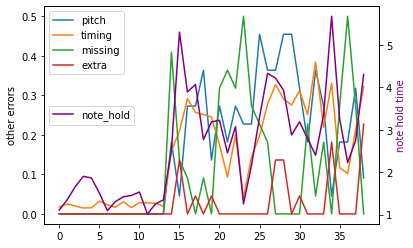

In [39]:
"""
Plot errors of good practice opportunties.
"""
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

ax.plot(data.iloc[:,2], label="pitch")
ax.plot(data.iloc[:,4], label="timing")
ax.plot(data.iloc[:,5], label="missing")
ax.plot(data.iloc[:,6], label="extra")

ax2 = ax.twinx()
ax2.plot(data.iloc[:,3], label="note_hold", color="purple")
ax2.set_ylabel("note hold time", color ="purple")
ax.set_ylabel("other errors")
ax.legend()
ax2.legend(loc="center left")
plt.show()

In [35]:
"""fig.savefig('mock_data_errors.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')"""

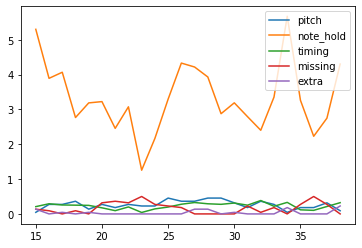

In [11]:
"""
Plot errors of bad practice opportunities
"""

plt.plot(data.iloc[15:,2], label="pitch")
plt.plot(data.iloc[15:,3], label="note_hold")
plt.plot(data.iloc[15:,4], label="timing")
plt.plot(data.iloc[15:,5], label="missing")
plt.plot(data.iloc[15:,6], label="extra")
plt.legend()
plt.show()

In [12]:
"""
This calculates the emission probability for the simple HMM model. Which means each input/state pair gives
its probability.
"""
import math
X = np.array(X)
model._compute_log_likelihood(X)

array([[5.0802411710920445, 0.14854173524939984],
       [0.39368424437015825, -5.833764608782703],
       [4.480857005211174, 1.327247083226312],
       [3.6352092692303795, 0.239503185744939],
       [2.8054263815391502, 0.7089473188761346],
       [-2.600709661206417, 0.2756114190384844],
       [-2.5023691857461783, 2.468120021741159],
       [-2.7523172061649213, 2.414665861587668],
       [-3.952550417051807, 2.052487913431193],
       [2.8054263815391502, 0.7089473188761346],
       [-2.600709661206417, 0.2756114190384844],
       [-2.640016003047222, -0.10833186381485271],
       [2.1545987624670313, 1.1969067869886296],
       [2.7602342480795397, 2.2630075744996745],
       [4.482090603462482, 1.9839545939798027],
       [1.3822060033889705, 1.1449539455038793],
       [4.907623793671881, 2.273765347479586],
       [-12.684072926177386, -1.8416439251892012],
       [4.268035274441368, 1.3522813764090782],
       [2.7451210286647405, -4.982212269203863],
       [5.054294435454

In [13]:
"""For saving models:"""
#with open("playRhythmBinary.pkl", "wb") as file: pickle.dump(model, file)

'For saving models:'

In [18]:
"""
Calculates and prints the state with the min/max error value(observation/performance errors) according
to the raw errors and another error metric, which adds 1 to each state if its the min/max error value in 
that error section(eg pitch).
This is then used to normalise the model. That means, that the transition matrix is saved in a way, that
column/row 0 is always the unmastered state (high error) and column/row 1 is always the mastered state 
(low error).
"""
directory = "left hand"
with open("BestThreeStates/" + directory + "/" + directory + "4.pkl", "rb") as file:
            model = pickle.load(file)
print("Transition matrix")
print(model.transmat_)

#print("Model means")
#print(model.means_)
mus = model.means_

state0 = mus[0][5] + mus[0][11]
state1 = mus[1][5] + mus[1][11]
state2 = mus[2][5] + mus[2][11]

print([state0, state1, state2])

max_error = np.argmax([state0, state1, state2])
min_error = np.argmin([state0, state1, state2])

new_max, new_min = new_error_comp(mus)

print("state with min_error:", min_error)
print("state with max error:", max_error)

print("state with new min_error:", new_min)
print("state with new max error:", new_max)
#means
#covariance
#transition
indizes = []

"""
if new_min != 2:
    if new_min == 0:
        indizes = [2,1,0]
        model.transmat_ = swap_row(swap_column(model.transmat_, indizes), indizes)
        model.means_ = swap_row(model.means_, indizes)
    elif new_min == 1:
        print("Wow, hier läuft was schief! Das Model sollte raus")
"""
indizes = [2,1,0]
model.transmat_ = swap_row(swap_column(model.transmat_, indizes), indizes)
model.means_ = swap_row(model.means_, indizes)

print("Transition matrix after")
print(model.transmat_)

        
with open("left hand4_new.pkl", "wb") as file: pickle.dump(model, file)


Transition matrix
[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.25025781e-02 7.49995673e-01 1.87501749e-01]
 [0.00000000e+00 1.00000000e+00 7.52262820e-33]]
[1.1825672926018316, 1.0598242347352753, 1.9520265746498267]
min -1 -2 3
state with min_error: 1
state with max error: 2
state with new min_error: 1
state with new max error: 2
Transition matrix after
[[7.52262820e-33 1.00000000e+00 0.00000000e+00]
 [1.87501749e-01 7.49995673e-01 6.25025781e-02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [15]:
"""
Calculates another min/max state in regards to errors, as described above.
"""
def new_error_comp(mus):
    state0 = state1 = state2 = 0
    for i in range(len(mus[0])):
        emax = np.argmax([mus[0][i], mus[1][i], mus[2][i]])
        emin = np.argmin([mus[0][i], mus[1][i], mus[2][i]])
        if emax == 0:
            state0 += 1
        elif emax == 1:
            state1 += 1
        elif emax == 2:
            state2 += 1
        if emin == 0:
            state0 -= 1
        elif emin == 1:
            state1 -= 1
        elif emin == 2:
            state2 -= 1
    new_max = np.argmax([state0, state1, state2])
    new_min = np.argmin([state0, state1, state2])
    print("min", state0, state1, state2)
    return new_max, new_min

In [16]:
def swap_column(arr, indizes):
    arr[:, [0,1,2]] = arr[:, indizes]
    return arr

In [17]:
def swap_row(arr, indizes):
    arr[[0,1,2]] = arr[indizes]
    return arr

In [ ]:
"""
if new_min == 0 and new_max == 2:
    # 0 -> 2, 2-> 0
    indizes = [2,1,0]
elif new_min == 0 and new_max == 1:
    # 0 -> 2, 1-> 0, 2 -> 1
    indizes = [2,0,1]
elif new_min == 1 and new_max == 2:
    # 0 -> 1, 1 -> 2, 2 -> 0
    indizes = [1,2,0]
elif new_min == 1 and new_max == 0:
    # 1 -> 2, 2 -> 1
    indizes = [0,2,1]
elif new_min == 2 and new_max == 1:
    # 1 -> 0, 0 -> 1
    indizes = [1,0,2]
else:
    indizes = [0,1,2]
model.transmat_ = swap_row(swap_column(model.transmat_, indizes), indizes)
model.means_ = swap_row(model.means_, indizes)
#model.covars_ = swap_row(model.covars_, indizes)

print(model.transmat_)
#wit

In [ ]:
directory = "single note"
X = []
lengths = []
for filename in os.listdir(directory):
    X, lengths = get_sequence(directory + "/" + filename, X, lengths)
X = np.array(X)
plt.hist(X[:,0])
print(X[:,0])